In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class Quantizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return (X * 10).astype(int)

In [3]:
%load_ext google.cloud.bigquery

In [4]:
%%bigquery df_indicadores_por_plano

SELECT 

    tb1.IdApoliceSubFaturaPlano, tb1.dtCompetenciaContapaga, COUNT(DISTINCT idBeneficiario) AS qtd_vidas,
    
    -- Indicadores ambulatoriais.
    SUM(IF(AMB_dsClassPassagem = "Consulta Eletiva", 1, 0)) / COUNT(DISTINCT idBeneficiario)                                 AS consultas_eletivas_por_beneficiario,
    SUM(IF(AMB_dsClassPassagem = "Pronto-Socorro", 1, 0)) / COUNT(DISTINCT idBeneficiario)                                   AS consultas_ps_por_beneficiario,
    SUM(IF(AMB_dsClassPassagem = "Exames" AND AMBINT_dsCategoriaExame = "Simples", 1, 0)) / COUNT(DISTINCT idBeneficiario)   AS exames_simples_por_beneficiario,
    SUM(IF(AMB_dsClassPassagem = "Exames" AND AMBINT_dsCategoriaExame = "Especiais", 1, 0)) / COUNT(DISTINCT idBeneficiario) AS exames_especiais_por_beneficiario,
    SUM(IF(AMBINT_dsTipoTerapia = "Psicologia", 1, 0)) / COUNT(DISTINCT idBeneficiario)                                      AS psicoterapias_por_beneficiario,
    
    -- TODO: exames_por_consulta_ps
    -- TODO: exames_por_consulta_eletiva
    -- TODO: perc_consultas_de_urgencia
    -- TODO: perc_conversao_ps_internacao
        
    -- Indicadores de internação.
    SAFE_DIVIDE(SUM(INT_vrPagoProcedimentoContaPaga_Internacao), COUNT(DISTINCT INT_IdPassagem_Internacao))                  AS preco_medio_internacao,
    SAFE_DIVIDE(COUNT(DISTINCT INT_IdPassagem_Internacao), COUNT(DISTINCT idBeneficiario))                                   AS taxa_internacao,
    SAFE_DIVIDE(SUM(IF(INT_FlagNeoNatal = "Sim", 1, 0)), SUM(IF(INT_FlagParto = "Sim", 1, 0)))                               AS perc_uti_neonatal_x_partos,
    SAFE_DIVIDE(SUM(IF(INT_FlagINTernacaoUTI = "Sim", 1, 0)), COUNT(DISTINCT INT_IdPassagem_Internacao))                     AS perc_interncoes_uti,
        
    -- TODO: permanencia_media_internacao
    -- TODO: perc_internacoes_curtas
    -- TODO: perc_reinternacoes
        
    -- Indicadores financeiros.
    SUM(vrPagoProcedimentoContaPaga) / COUNT(DISTINCT idBeneficiario)                                                        AS sinistro_per_capita,
    SAFE_DIVIDE(SUM(vrCoParticipacaoProcedimentoContaPaga), SUM(vrPagoProcedimentoContaPaga))                                AS perc_copart_sinistro,
    
    -- TODO: sinistro_por_grupo_despesa
    -- TODO: premio_per_capita
    
    1                                                                                                                        AS flag_indicador_plano

FROM
    cosmic-shift-235317.fenix_bi.view_fato_sinistro AS tb1

INNER JOIN (
    SELECT 
        IdApoliceSubFaturaPlano, MAX(dtCompetenciaContapaga) AS dtCompetenciaContapaga
    FROM
        cosmic-shift-235317.fenix_bi.view_fato_sinistro
    GROUP BY IdApoliceSubFaturaPlano
) AS tb2 
    ON tb1.IdApoliceSubFaturaPlano = tb2.IdApoliceSubFaturaPlano AND tb1.dtCompetenciaContapaga = tb2.dtCompetenciaContapaga

GROUP BY tb1.IdApoliceSubFaturaPlano, tb1.dtCompetenciaContapaga
ORDER BY tb1.IdApoliceSubFaturaPlano, tb1.dtCompetenciaContapaga

Downloading: 100%|██████████| 2799/2799 [00:04<00:00, 663.55rows/s]


In [5]:
df_indicadores_por_plano.head()

IdApoliceSubFaturaPlano dtCompetenciaContapaga  qtd_vidas  \
0                        0             2021-05-01         10   
1                       13             2021-05-01          2   
2                       14             2021-05-01          2   
3                       31             2018-08-01          1   
4                       32             2021-05-01          1   

   consultas_eletivas_por_beneficiario  consultas_ps_por_beneficiario  \
0                                  0.4                            0.4   
1                                  0.5                            0.0   
2                                  1.0                            0.0   
3                                  0.0                            0.0   
4                                  3.0                            0.0   

   exames_simples_por_beneficiario  exames_especiais_por_beneficiario  \
0                              3.1                                0.7   
1                             24.5                                1.0   
2                             20.0                                3.0   
3                             23.0                                2.0   
4                              2.0                                2.0   

   psicoterapias_por_beneficiario preco_medio_internacao  taxa_internacao  \
0                             0.4                   None              0.0   
1                             0.0                   None              0.0   
2                             0.0                   None              0.0   
3                             0.0                   None              0.0   
4                             0.0                   None              0.0   

   perc_uti_neonatal_x_partos  perc_interncoes_uti sinistro_per_capita  \
0                         NaN                  NaN       376.408000000   
1                         NaN                  NaN       953.545000000   
2                         NaN                  NaN      1796.895000000   
3                         NaN                  NaN       367.590000000   
4                         NaN                  NaN      2362.440000000   

  perc_copart_sinistro  flag_indicador_plano  
0                 0E-9                     1  
1                 0E-9                     1  
2                 0E-9                     1  
3                 0E-9                     1  
4                 0E-9                     1

In [6]:
X = df_indicadores_por_plano \
    .drop(columns=['IdApoliceSubFaturaPlano', 'dtCompetenciaContapaga', 'flag_indicador_plano']) \
    .fillna(0)

X.head()

qtd_vidas  consultas_eletivas_por_beneficiario  \
0         10                                  0.4   
1          2                                  0.5   
2          2                                  1.0   
3          1                                  0.0   
4          1                                  3.0   

   consultas_ps_por_beneficiario  exames_simples_por_beneficiario  \
0                            0.4                              3.1   
1                            0.0                             24.5   
2                            0.0                             20.0   
3                            0.0                             23.0   
4                            0.0                              2.0   

   exames_especiais_por_beneficiario  psicoterapias_por_beneficiario  \
0                                0.7                             0.4   
1                                1.0                             0.0   
2                                3.0                             0.0   
3                                2.0                             0.0   
4                                2.0                             0.0   

  preco_medio_internacao  taxa_internacao  perc_uti_neonatal_x_partos  \
0                      0              0.0                         0.0   
1                      0              0.0                         0.0   
2                      0              0.0                         0.0   
3                      0              0.0                         0.0   
4                      0              0.0                         0.0   

   perc_interncoes_uti sinistro_per_capita perc_copart_sinistro  
0                  0.0       376.408000000                 0E-9  
1                  0.0       953.545000000                 0E-9  
2                  0.0      1796.895000000                 0E-9  
3                  0.0       367.590000000                 0E-9  
4                  0.0      2362.440000000                 0E-9

In [7]:
preprocessing_pipe = Pipeline([
    ("feature_engineering", PolynomialFeatures(degree=50, include_bias=False, interaction_only=True)),
    ("scale_0_1", MinMaxScaler()),
    ("discretize", Quantizer()),
    ("pca", PCA(n_components=3, random_state=42))
])

clustering_pipe = Pipeline([
    ("cluster", KMeans(n_clusters=5, n_init=50, max_iter=500, random_state=42))
])

preprocessed_X = preprocessing_pipe.fit_transform(X)
clusters = clustering_pipe.fit_predict(preprocessed_X)
centroids = clustering_pipe._final_estimator.cluster_centers_

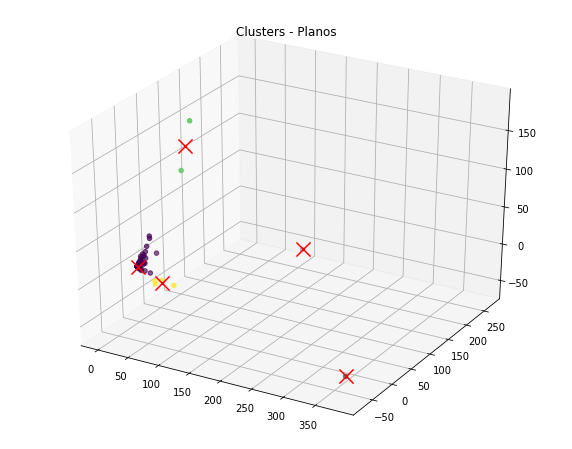

In [8]:
# Clusters 3D scatter plot.
fig, ax = plt.figure(figsize=(10, 8)), plt.axes(projection='3d')

x, y, z = preprocessed_X[:, 0], preprocessed_X[:, 1], preprocessed_X[:, 2]
ax.scatter3D(x, y, z, c=clusters);

x, y, z = centroids[:, 0], centroids[:, 1], centroids[:, 2]
ax.scatter3D(x, y, z, marker="x", s=200, c="red", depthshade=False);
plt.title('Clusters - Planos');